In [1]:
# Librerias utilizadas.
## Importación de datos.
from sqlalchemy import create_engine
## Tratamiento de datos.
import pandas as pd
import numpy as np
## Gráficos.
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10
## Preprocesado y modelado.
from sklearn import datasets, linear_model, metrics, svm, preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV
## Configuración warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Nombre de usuario, contraseña y BBDD MySQL.
mysql_address = '172.30.248.86'
mysql_port = '3306'
mysql_username = 'mms'
mysql_password = 'agedb'
mysql_dbname = 'aoe2de'
# String que contiene la información necesaria para el login de MySQL.
mysql_str = ('mysql+pymysql://{username}:{password}@{ipaddress}:{port}/{dbname}'
.format(username = mysql_username,
password = mysql_password,
ipaddress = mysql_address,
port = mysql_port,
dbname = mysql_dbname))

In [3]:
# Query para importar los datos desde MySQL.
cnx = create_engine(mysql_str)
query = f"""
/*ALL PLAYERS*/
SELECT
    matches.duration_minutes AS 'duration',
    players.civ,
    players.won
FROM
    matches, players
WHERE
    matches.match_id = players.match_id
AND
    matches.map_type = 'Arabia'
AND
    matches.rating_type = '1v1 Random Map'
AND
    matches.version = '47820'    
"""
df = pd.read_sql_query(query, con=cnx)
# Muestreo aleatorio simple de 10000 observaciones.
# df = df.sample(n=30000, random_state=2021).reset_index(drop=True)
df.shape

(1326292, 3)

In [4]:
df.head(10)

,duration,civ,won
0,34,Vikings,0
1,34,Saracens,1
2,19,Mayans,1
3,19,Japanese,0
4,19,Mayans,0
5,19,Magyars,1
6,18,Burgundians,0
7,18,Mayans,1
8,27,Khmer,1
9,27,Franks,0


In [5]:
df.tail(10)

,duration,civ,won
1326282,10,Celts,1
1326283,10,Khmer,0
1326284,36,Ethiopians,1
1326285,36,Ethiopians,0
1326286,33,Persians,1
1326287,33,Persians,0
1326288,22,Ethiopians,0
1326289,22,Franks,1
1326290,14,Franks,0
1326291,14,Franks,1


In [6]:
# Comprobación de valores NaN en el dataset.
df.isna().sum()

duration    0
civ         0
won         0
dtype: int64

In [7]:
# Eliminar registros donde tenemos alguna variable NaN.
df.dropna(inplace=True)
df.shape

(1326292, 3)

In [8]:
# Convertir variables object a category.
df['civ'] = df['civ'].astype('category')

In [9]:
# Comprobación de cada tipo de variable.
df.dtypes

duration       int64
civ         category
won            int64
dtype: object

In [10]:
# Estadísticos básicos de las variables numéricas.
df.describe()

,duration,won
count,1.326292e+06,1326292.0
mean,2.432248e+01,0.5
std,1.108719e+01,0.5
min,0.000000e+00,0.0
25%,1.800000e+01,0.0
50%,2.400000e+01,0.5
75%,3.000000e+01,1.0
max,2.400000e+02,1.0


<AxesSubplot:xlabel='duration', ylabel='Density'>

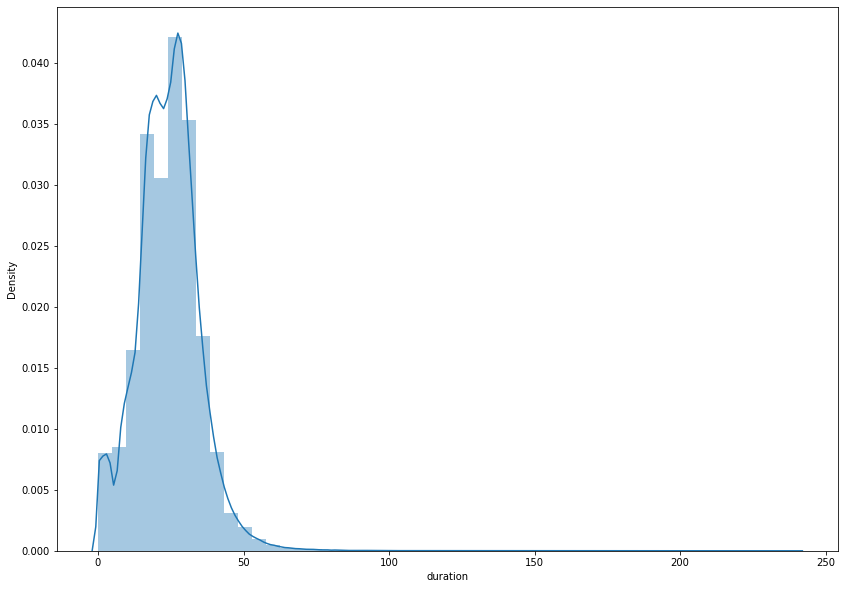

In [11]:
sns.distplot(df.duration)

<AxesSubplot:xlabel='duration'>

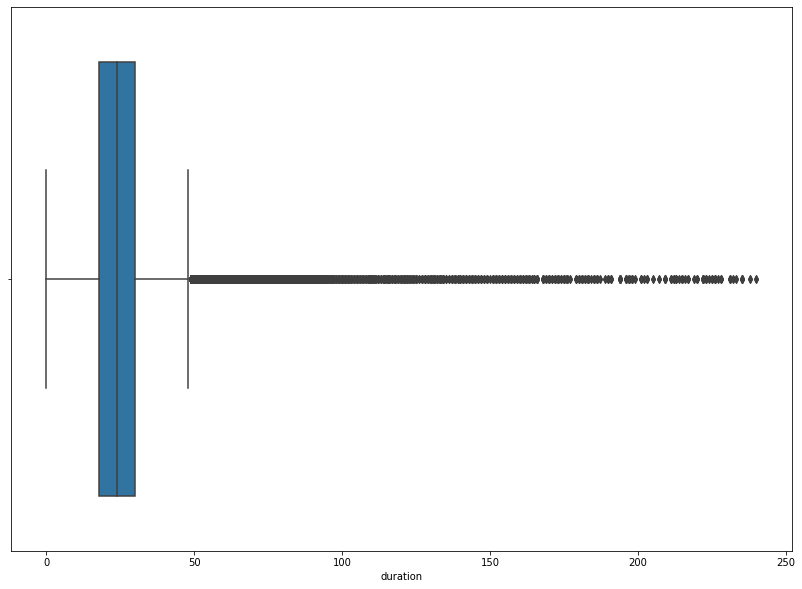

In [12]:
sns.boxplot(df.duration)

In [13]:
# Valores únicos de la variable "civ".
civs = df.civ.unique().tolist()
civs.sort()
# Creación de la función personalizada "obtener los índices de frecuencia por país".
def get_frequency_rates_by_civ(df):
    return pd.DataFrame(df.civ.value_counts(normalize=True)).reset_index().rename(columns={"index": "civ", "civ": "frequency"})
# Creación de la función personalizada "obtener las tasas de victoria por país".
def get_win_rates_by_civ(df):
    return (
        df.groupby("civ")["won"]
            .mean()
            .reset_index()
            .rename(columns={"won": "win_rate"})
            .sort_values("win_rate", ascending=False)
            .reset_index(drop=True)
    )
# Aplicación de las dos funciones creadas anteriormente.
frequency_rates_civ = get_frequency_rates_by_civ(df)
win_rates_civ              = get_win_rates_by_civ(df)

Text(0.5, 1.0, 'Frecuencia de partidas por civilización')

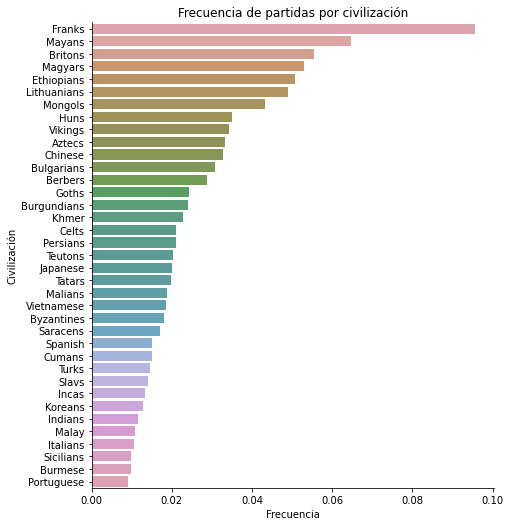

In [14]:
sns.catplot(y="civ",
                        x="frequency", 
                        data=frequency_rates_civ,
                        saturation=0.5,
                        kind="bar",
                        ci=None,
                        aspect=1,
                        height=7,
                        orient="h",
                        order=frequency_rates_civ.sort_values('frequency', ascending=False).civ)
plt.ylabel("Civilización")
plt.xlabel("Frecuencia")
plt.title("Frecuencia de partidas por civilización")

Text(0.5, 1.0, 'Tasa de victorias por civilización')

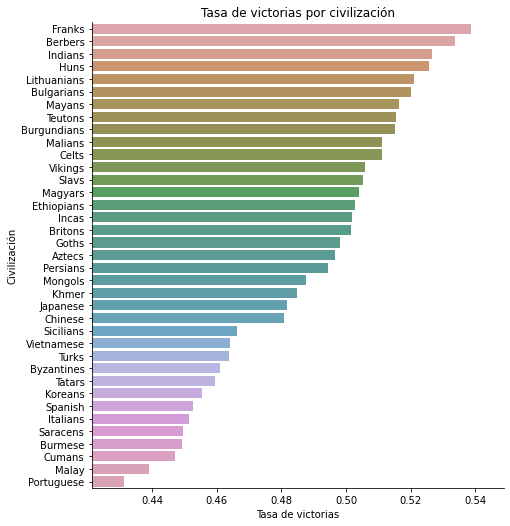

In [15]:
sns.catplot(y="civ",
                        x="win_rate", 
                        data=win_rates_civ,
                        saturation=0.5,
                        kind="bar",
                        ci=None,
                        aspect=1,
                        height=7,
                        orient="h", 
                        order=win_rates_civ.sort_values('win_rate', ascending=False).civ)
plt.ylabel("Civilización")
plt.xlabel("Tasa de victorias")
lim_sup = float(win_rates_civ.win_rate.head(1) + 0.01)
lim_inf = float(win_rates_civ.win_rate.tail(1) - 0.01)
plt.xlim(lim_inf, lim_sup)
plt.title("Tasa de victorias por civilización")

In [16]:
# Función para la creación de variables dummy.
def create_dummies(df, var_name):
    dummy = pd.get_dummies(df[var_name], prefix=var_name)
    df = df.drop(var_name, axis = 1)
    df = pd.concat([df, dummy ], axis = 1)
    return df
# Creación variables dummy.
categorical = ["civ"]
for category in categorical:
    df = create_dummies(df, category)

In [17]:
# Transformación de las entidades escalando cada entidad a un rango determinado.
scaler = MinMaxScaler() 
arr_scaled = scaler.fit_transform(df) 
df_scaled = pd.DataFrame(arr_scaled, columns=df.columns,index=df.index)
df_scaled

,duration,won,civ_Aztecs,civ_Berbers,civ_Britons,civ_Bulgarians,civ_Burgundians,civ_Burmese,civ_Byzantines,civ_Celts,...,civ_Portuguese,civ_Saracens,civ_Sicilians,civ_Slavs,civ_Spanish,civ_Tatars,civ_Teutons,civ_Turks,civ_Vietnamese,civ_Vikings
0,0.141667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.141667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.079167,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.079167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.079167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326287,0.137500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1326288,0.091667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1326289,0.091667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1326290,0.058333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df_vars=df_scaled.columns.values.tolist()
y_var=['won']
X_var=[i for i in df_vars if i not in y_var]
y = pd.DataFrame(data=df_scaled,columns=y_var)
X = pd.DataFrame(data=df_scaled,columns=X_var)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

In [19]:
X_train

,duration,civ_Aztecs,civ_Berbers,civ_Britons,civ_Bulgarians,civ_Burgundians,civ_Burmese,civ_Byzantines,civ_Celts,civ_Chinese,...,civ_Portuguese,civ_Saracens,civ_Sicilians,civ_Slavs,civ_Spanish,civ_Tatars,civ_Teutons,civ_Turks,civ_Vietnamese,civ_Vikings
1201173,0.104167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1320230,0.112500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
951248,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
337337,0.116667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207221,0.104167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743382,0.112500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
675678,0.170833,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1182317,0.116667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
224597,0.158333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
X_test

,duration,civ_Aztecs,civ_Berbers,civ_Britons,civ_Bulgarians,civ_Burgundians,civ_Burmese,civ_Byzantines,civ_Celts,civ_Chinese,...,civ_Portuguese,civ_Saracens,civ_Sicilians,civ_Slavs,civ_Spanish,civ_Tatars,civ_Teutons,civ_Turks,civ_Vietnamese,civ_Vikings
928682,0.012500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1237377,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
499987,0.104167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902394,0.141667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1190998,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262974,0.170833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
188709,0.145833,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
813284,0.141667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
905673,0.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
y_train

,won
1201173,1.0
1320230,1.0
951248,0.0
337337,1.0
207221,1.0
...,...
743382,0.0
675678,1.0
1182317,1.0
224597,0.0


In [23]:
y_test

,won
928682,1.0
1237377,0.0
499987,0.0
902394,1.0
1190998,0.0
...,...
262974,1.0
188709,0.0
813284,0.0
905673,1.0


In [24]:
y_train.mean()

won    0.500399
dtype: float64

In [25]:
y_test.mean()

won    0.49907
dtype: float64

In [28]:
df_scaled.won.mean()

0.5

In [42]:
c = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for i  in c:
    model = LogisticRegression(solver='newton-cg', random_state=2021)
    model.fit(X_train, y_train)
    print('C:' +str(i))
    print('Score:' +str(model.score(X_test, y_test)))
    

C:0.1
Score:0.5208526017371723
C:0.2
Score:0.5208526017371723
C:0.3
Score:0.5208526017371723
C:0.4
Score:0.5208526017371723
C:0.5
Score:0.5208526017371723
C:0.6
Score:0.5208526017371723
C:0.7
Score:0.5208526017371723
C:0.8
Score:0.5208526017371723
C:0.9
Score:0.5208526017371723
C:1
Score:0.5208526017371723


In [58]:
model = LogisticRegression(solver='newton-cg', random_state=2021)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5208526017371723

In [54]:
model = LogisticRegressionCV(solver='newton-cg', random_state=2021)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5208526017371723

In [32]:
model = LogisticRegression(solver='lbfgs', random_state=2021)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5208551150072382

In [55]:
model = LogisticRegressionCV(solver='lbfgs', random_state=2021)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5208551150072382

In [33]:
model = LogisticRegression(solver='liblinear', random_state=2021)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5208526017371723

In [34]:
model = LogisticRegression(solver='sag', random_state=2021)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5208526017371723

In [35]:
model = LogisticRegression(solver='saga', random_state=2021)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5208526017371723

In [39]:
model = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5, random_state=2021)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5208551150072382

In [52]:
model = linear_model.SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5208526017371723

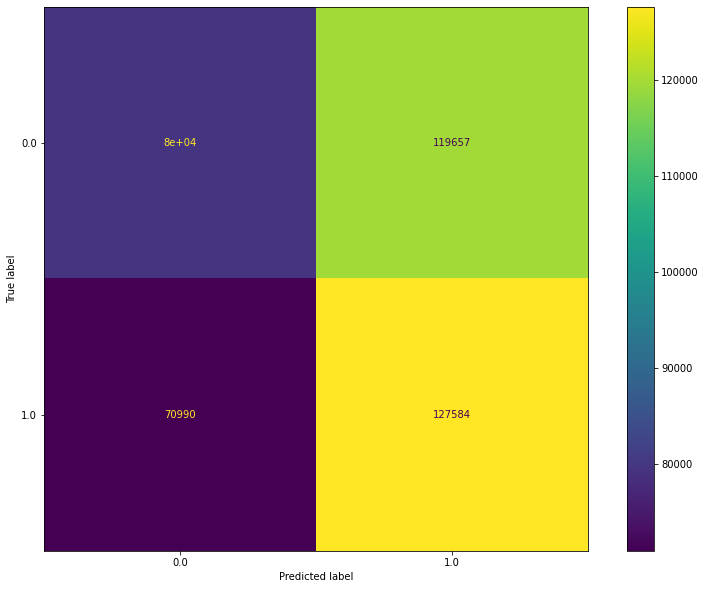

In [66]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test)

In [60]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
y_pred = model.predict(X_test)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

Accuracy Score : 0.5208526017371723
Precision Score : 0.5160309172022439
Recall Score : 0.642501032360732
F1 Score : 0.572362975673766


In [67]:
#Grid Search
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy')
grid_clf_acc.fit(X_train, y_train)

#Predict values based on new parameters
y_pred_acc = grid_clf_acc.predict(X_test)

# New Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)

Accuracy Score : 0.5208551150072382
Precision Score : 0.5160330043682252
Recall Score : 0.642501032360732
F1 Score : 0.5723642595342452


array([[ 79658, 119656],
       [ 70990, 127584]], dtype=int64)

In [71]:
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [76]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200, random_state=2021)
distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distributions, random_state=0)
search = clf.fit(X_train, y_train)
search.best_params_

{'C': 2.4942547871438894, 'penalty': 'l2'}

In [78]:
search.score(X_test, y_test)

0.5208551150072382

In [77]:
# Create first pipeline for base without reducing features.
from sklearn import pipeline
pipe = pipeline.Pipeline([('classifier' , RandomForestClassifier())])
# pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [79]:
from sklearn.linear_model import Perceptron
perceptron = Perceptron(tol=1e-3, random_state=0)
perceptron.fit(X_train, y_train)
perceptron.score(X_test, y_test)

0.4937545238861187

In [80]:
from sklearn.linear_model import PassiveAggressiveClassifier
passive = PassiveAggressiveClassifier(tol=1e-3, random_state=0)
passive.fit(X_train, y_train)
passive.score(X_test, y_test)

0.4962552276017372

In [83]:
from sklearn.preprocessing import PolynomialFeatures
polynomial = PolynomialFeatures(degree=2)
polynomial.fit(X_train, y_train)
polynomial.score(X_test, y_test)

AttributeError: 'PolynomialFeatures' object has no attribute 'score'

In [ ]:
# Selección de rasgos para el modelo.
features = len(df_scaled.columns.values)
summary_models_logreg = pd.DataFrame(columns=['initial_features', 
                                                                                                       'final_features',
                                                                                                       'aic',
                                                                                                       'bic',
                                                                                                       'df_residuals',
                                                                                                       'r_squared',
                                                                                                       'score_accuracy',
                                                                                                       'roc_auc_score'])
for f in range(4, features, 4):
    print("-------------")
    print("Features:", f)
    # Recursive Feature Elimination
    df_vars=df_scaled.columns.values.tolist()
    y_var=['won']
    X_var=[i for i in df_vars if i not in y_var]
    y = pd.DataFrame(data=df_scaled,columns=y_var)
    X = pd.DataFrame(data=df_scaled,columns=X_var)
    logreg_sklearn = LogisticRegression()
    rfe = RFE(logreg_sklearn, f)
    try:
        rfe = rfe.fit(X, y.values.ravel())
        cols = []
        for var, selected, rank in zip(X_var, rfe.support_, rfe.ranking_):
            if selected == True:
                cols.append(var)
        X=df_scaled[cols]
        y=df_scaled['won']

        # Implementing the model
        logreg_sm=sm.Logit(y,X)
        logreg_sm_results=logreg_sm.fit()

        # Remove unsignificant variables
        pvalues = list(logreg_sm_results.pvalues)
        cols_s = pd.DataFrame(list(zip(cols, pvalues)))
        cols_s.columns = ["variable", "pvalue"]
        cols_s = cols_s[cols_s["pvalue"] <= 0.05]
        cols_s.reset_index(inplace=True, drop=True)
        cols_s = list(cols_s["variable"])
        X=df_scaled[cols_s]
        y=df_scaled['won']
        logreg_sm=sm.Logit(y,X)
        logreg_sm_results=logreg_sm.fit()

        # Logistic Regression Model Fitting
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
        logreg_sklearn = LogisticRegression()
        logreg_sklearn.fit(X_train, y_train)
        from sklearn.metrics import roc_auc_score
        logreg_sklearn_roc_auc = roc_auc_score(y_test, logreg_sklearn.predict(X_test))

        # Final features.
        final_features = len(logreg_sm_results.params)
        # Akaike’s information criteria.
        aic = round(logreg_sm_results.aic, 4)
        # Bayes’ information criteria.
        bic = round(logreg_sm_results.bic, 4)
        # Residual degrees of freedom.
        df_resid = int(logreg_sm_results.df_resid)
        # R squared.
        rsquared = round(logreg_sm_results.prsquared, 4)
        # Score of logreg_sklearn.
        score_accuracy = round(logreg_sklearn.score(X_test, y_test), 4)
        # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
        roc_auc_score = round(logreg_sklearn_roc_auc, 4)

        # Append to final dataframe summary of logistic regression.
        data_to_append = [f, final_features, aic, bic, df_resid, rsquared, score_accuracy, roc_auc_score]
        a_series = pd.Series(data_to_append, index=summary_models_logreg.columns)
        summary_models_logreg = summary_models_logreg.append(a_series, ignore_index=True)
    except:
        pass

In [ ]:
summary_models_logreg = summary_models_logreg[summary_models_logreg["r_squared"]>0]
summary_models_logreg = summary_models_logreg.sort_values(by=['score_accuracy', 'roc_auc_score', 'r_squared'], ascending=[False, False, False]).reset_index(drop=True)
summary_models_logreg.head(10)

In [ ]:
f = int(summary_models_logreg.initial_features[0])
# Recursive Feature Elimination
df_vars=df_scaled.columns.values.tolist()
y_var=['won']
X_var=[i for i in df_vars if i not in y_var]
y = pd.DataFrame(data=df_scaled,columns=y_var)
X = pd.DataFrame(data=df_scaled,columns=X_var)
logreg_sklearn = LogisticRegression()
rfe = RFE(logreg_sklearn, f)
rfe = rfe.fit(X, y.values.ravel())
cols = []
for var, selected, rank in zip(X_var, rfe.support_, rfe.ranking_):
    if selected == True:
        cols.append(var)
X=df_scaled[cols]
y=df_scaled['won']

# Implementing the model
logreg_sm=sm.Logit(y,X)
logreg_sm_results=logreg_sm.fit()

# Remove unsignificant variables
pvalues = list(logreg_sm_results.pvalues)
cols_s = pd.DataFrame(list(zip(cols, pvalues)))
cols_s.columns = ["variable", "pvalue"]
cols_s = cols_s[cols_s["pvalue"] <= 0.05]
cols_s.reset_index(inplace=True, drop=True)
cols_s = list(cols_s["variable"])
X=df_scaled[cols_s]
y=df_scaled['won']
logreg_sm=sm.Logit(y,X)
logreg_sm_results=logreg_sm.fit()

In [ ]:
logreg_sm_results.summary2()

In [ ]:
coefficients = dict(logreg_sm_results.params)
coefficients = pd.DataFrame.from_dict(coefficients, orient='index').reset_index(level=0)
coefficients.columns = ['Variable', 'Coeficiente']
coefficients.sort_values(by="Coeficiente", ascending=False)

In [ ]:
for index, row in coefficients.iterrows():
    print("Si el jugador escoge la civilización " + row["Variable"] + " el cociente de probabilidad de victoria se incrementará en " + str(round(row["Coeficiente"], 3)))

In [ ]:
corr = X.corr().abs()
corr = corr[corr > 0.7]
corr

In [ ]:
from sklearn.metrics import plot_roc_curve

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)
ax=plt.gca()
# LogisticRegression
logreg_sklearn = LogisticRegression()
logreg_sklearn.fit(X_train, y_train)
logreg_sklearn_roc = plot_roc_curve(logreg_sklearn, X_test, y_test, ax=ax)
# SVC (Support Vector Classification)
svc_sklearn = SVC(random_state=2021)
svc_sklearn.fit(X_train, y_train)
svc_sklearn_roc = plot_roc_curve(svc_sklearn, X_test, y_test, ax=ax)
# RandomForestClassifier
rfc_sklearn = RandomForestClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
rfc_sklearn.fit(X_train, y_train)
rfc_sklearn_roc = plot_roc_curve(rfc_sklearn, X_test, y_test, ax=ax)
# GradientBoostingClassifier
gbc_sklearn = GradientBoostingClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
gbc_sklearn.fit(X_train, y_train)
gbc_sklearn_roc = plot_roc_curve(gbc_sklearn, X_test, y_test, ax=ax)
# AdaBoostClassifier
abc_sklearn = AdaBoostClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
abc_sklearn.fit(X_train, y_train)
abc_sklearn_roc = plot_roc_curve(abc_sklearn, X_test, y_test, ax=ax)
# BaggingClassifier
bgc_sklearn =BaggingClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
bgc_sklearn.fit(X_train, y_train)
bgc_sklearn_roc = plot_roc_curve(bgc_sklearn, X_test, y_test, ax=ax)

plt.title("Curva ROC")
plt.ylabel("TPR o  Sensibilidad")
plt.xlabel("FPR o 1-Especificidad")
plt.plot([0, 1], [0, 1],'r--')
rcParams['figure.figsize'] = 16, 10
# plt.rcParams["figure.figsize"] = (12, 12)
plt.show()

In [ ]:
# Scores.
score_lr     = round(logreg_sklearn.score(X_test, y_test), 5)
score_svc = round(svc_sklearn.score(X_test, y_test), 5)
score_rfc  = round(rfc_sklearn.score(X_test, y_test), 5)
score_gbc = round(gbc_sklearn.score(X_test, y_test), 5)
score_abc = round(abc_sklearn.score(X_test, y_test), 5)
score_bgc = round(bgc_sklearn.score(X_test, y_test), 5)
# Asignar datos de la lista.  
results = {'Model': ['LogisticRegression', 'SVC (SupportVectorClassifier)', 'RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'BaggingClassifier'],
               'Score': [score_lr, score_svc, score_rfc, score_gbc, score_abc, score_bgc]}  
# Crear DataFrame .
df_results = pd.DataFrame(results)  
# Imprimir listado de Scores.  
df_results.sort_values(by=['Score'], ascending=False, ignore_index=True)

In [ ]:
# Scores CV.
score_lr_cv     = round(cross_val_score(logreg_sklearn, X, y, cv=10).mean(), 5)
score_svc_cv = round(cross_val_score(svc_sklearn, X, y, cv=10).mean(), 5)
score_rfc_cv  = round(cross_val_score(rfc_sklearn, X, y, cv=10).mean(), 5)
score_gbc_cv = round(cross_val_score(gbc_sklearn, X, y, cv=10).mean(), 5)
score_abc_cv = round(cross_val_score(abc_sklearn, X, y, cv=10).mean(), 5)
score_bgc_cv = round(cross_val_score(bgc_sklearn, X, y, cv=10).mean(), 5)
# Asignar datos de la lista.   
results_cv = {'Model': ['LogisticRegression', 'SVC (SupportVectorClassifier)', 'RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'BaggingClassifier'],
               'Score CV 10': [score_lr_cv, score_svc_cv, score_rfc_cv, score_gbc_cv, score_abc_cv, score_bgc_cv]}  
# Crear DataFrame .
df_results_cv = pd.DataFrame(results_cv)  
# Imprimir listado de Scores CV.  
df_results_cv.sort_values(by=['Score CV 10'], ascending=False, ignore_index=True)

In [ ]:
y.mean()